<a href="https://www.kaggle.com/georgemorales/medical-cost-notebook-linear-regression?scriptVersionId=89803660" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/insurance/insurance.csv


This is my notebook on the medical cost dataset. I am studying linear regression at the time of writing this notebook so I will only be using linear regression on this notebook and apply the concepts I learned from the book "Introduction to Statistical Learning with Applications in R" (ISLR) by Gareth James, et.al.

In [2]:
df = pd.read_csv("/kaggle/input/insurance/insurance.csv")

Because we don't have a separate file for test dataset, we need to split the dataset into train and test. The test dataset will be used to evaluate the performance of the model on unseen data.

In [3]:
# Lets separate a test dataset from the dataframe using the Dataframe.sample() function.
test_df = df.sample(frac=0.20)
# then remove the samples from the original df, the remaining observations will be used for training.
train_df = df.drop(test_df.index)

We'll use the `train_df` to make a model for predicting the medical cost data set and the `test_df` to evaluate the linear model that we made. 

Let's check for missing values.

In [4]:
train_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620
4,32,male,28.88,0,no,northwest,3866.8552
5,31,female,25.74,0,no,southeast,3756.6216


In [5]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1070.0,39.176636,14.168755,18.0000,26.000000,39.000000,51.00000,64.00000
bmi,1070.0,30.636860,6.118125,15.9600,26.180000,30.230000,34.84875,53.13000
children,1070.0,1.079439,1.206564,0.0000,0.000000,1.000000,2.00000,5.00000
charges,1070.0,13308.828768,12209.268032,1121.8739,4590.249537,9494.108625,16746.65740,62592.87309


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1070 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1070 non-null   int64  
 1   sex       1070 non-null   object 
 2   bmi       1070 non-null   float64
 3   children  1070 non-null   int64  
 4   smoker    1070 non-null   object 
 5   region    1070 non-null   object 
 6   charges   1070 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 66.9+ KB


There are no missing values so we can proceed with EDA.

# EDA

In [7]:
# import libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns

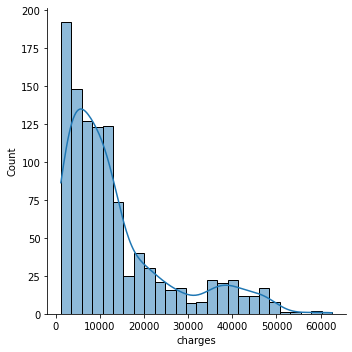

In [8]:
# Distribution of the response
sns.displot(x='charges', data = train_df, kde = True)

we can observe two normal distribution patterns here, one centered around 5,000 or 6,000 and one around 40,000.

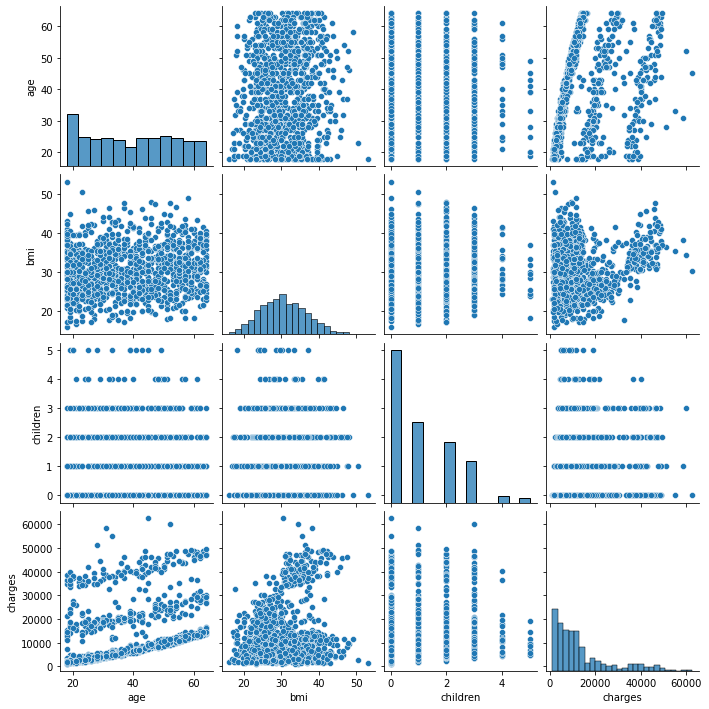

In [9]:
sns.pairplot(train_df)

There seems to be a pattern between charges and age

<AxesSubplot:xlabel='age', ylabel='charges'>

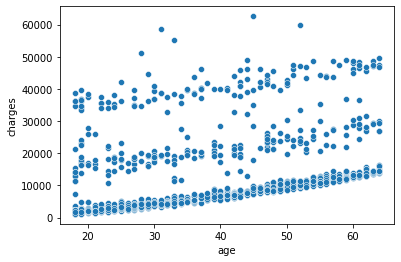

In [10]:
sns.scatterplot(x = 'age', y = 'charges', data = train_df)

We can observe three linear patterns here. 

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1070 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1070 non-null   int64  
 1   sex       1070 non-null   object 
 2   bmi       1070 non-null   float64
 3   children  1070 non-null   int64  
 4   smoker    1070 non-null   object 
 5   region    1070 non-null   object 
 6   charges   1070 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 99.2+ KB


Let's try separating the points using the categorical variables

<AxesSubplot:xlabel='age', ylabel='charges'>

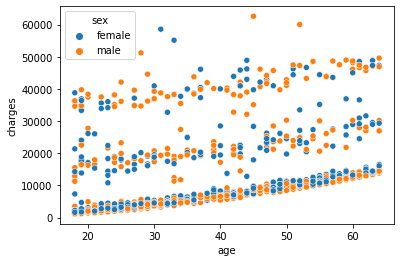

In [12]:
sns.scatterplot(x = 'age', y = 'charges', data = train_df, hue = 'sex')

<AxesSubplot:xlabel='age', ylabel='charges'>

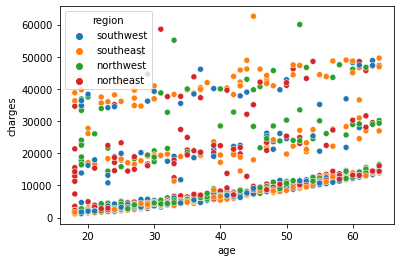

In [13]:
sns.scatterplot(x = 'age', y = 'charges', data = train_df, hue = 'region')

<AxesSubplot:xlabel='age', ylabel='charges'>

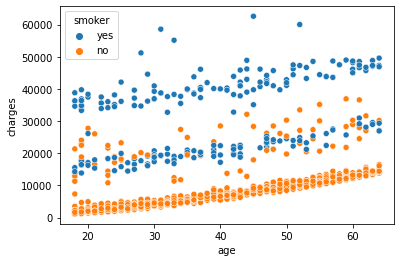

In [14]:
sns.scatterplot(x = 'age', y = 'charges', data = train_df, hue = 'smoker')

Smokers and non-smokers are dividing the linear patterns almost perfectly. Non-smokers tend to have less charges, and smokers have larger charges. Then there is the line in the middle with a mix of both.

<AxesSubplot:xlabel='smoker', ylabel='charges'>

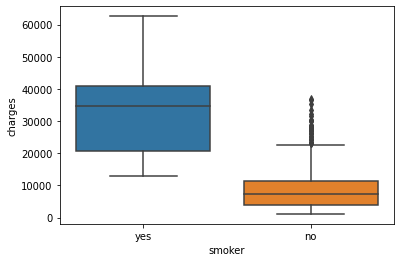

In [15]:
sns.boxplot(x = 'smoker', y = 'charges', data = train_df)

This explains the two normal distributions we observed before

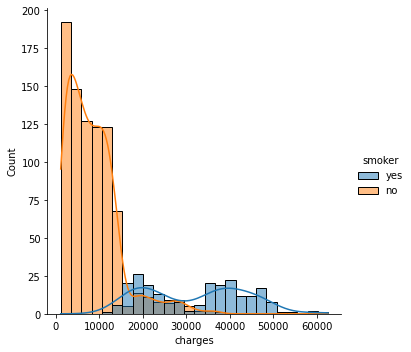

In [16]:
# Distribution of the response
sns.displot(x='charges', data = train_df, kde = True, hue = 'smoker')

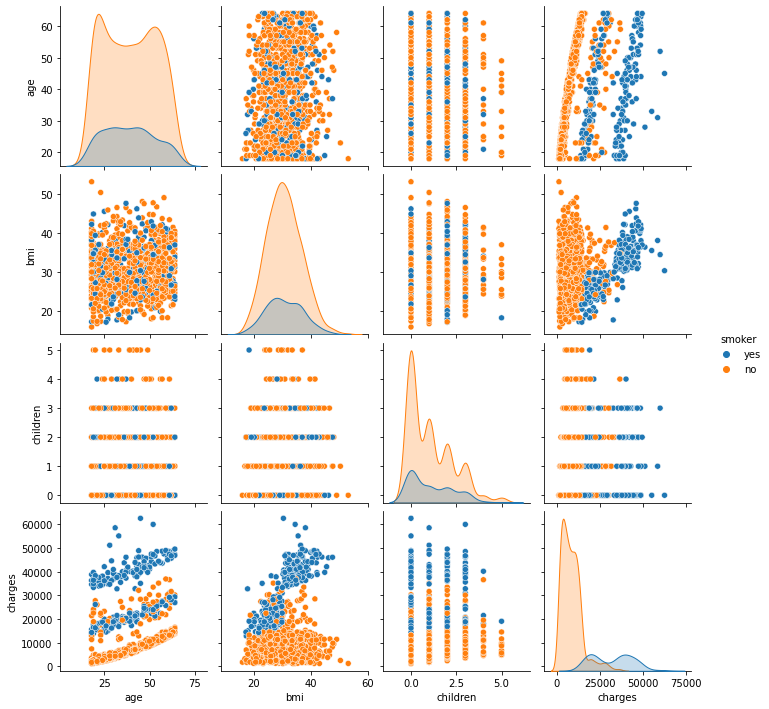

In [17]:
sns.pairplot(train_df, hue = 'smoker')

A  clear division from smokers and non-smokers can also be seen between charges and bmi.

# Preprocessing

In [18]:
train_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620
4,32,male,28.88,0,no,northwest,3866.8552
5,31,female,25.74,0,no,southeast,3756.6216


In [19]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
quantitative_var = train_df.drop('charges', axis=1).select_dtypes(include='number').columns
qualitative_var = train_df.select_dtypes(include='object').columns
train_df[quantitative_var]= scaler.fit_transform(train_df[quantitative_var])
train_df = pd.get_dummies(train_df, drop_first = True)

In [20]:
train_df.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,-1.424689,-0.447546,-0.895057,16884.9240,0,1,0,0,1
1,-1.495300,0.512347,-0.065870,1725.5523,1,0,0,1,0
2,-0.789192,0.386433,1.592504,4449.4620,1,0,0,1,0
4,-0.506748,-0.287291,-0.895057,3866.8552,1,0,1,0,0
5,-0.577359,-0.800760,-0.895057,3756.6216,0,0,0,1,0


# Modeling

Reading *Dannynynynyny123* and *Yosuke Shiraishi*'s discussion (link [here](https://www.kaggle.com/mirichoi0218/insurance/discussion/255722)), I am inspired to also create 3 different linear models and see the significance of each predictive variable to the response for each model. Before we do that, we should first figure out how to divide the observations so that we get the three lines.


## Separate the observations to low, middle, high

In [21]:
### We can see that the lowest line has a 'charges' that ranges from 0 up to about 15,000
### The middle from 15,000 up to 30,000
### The highest line from 30k onwards.
### Let's divide the observations according to this

### define a function to set each observation to a bin according to charges
def cluster(x):
    if x < 15000:
        return 'low'
    elif x < 30000:
        return 'middle'
    else:
        return 'high'
### apply the function to the dataframe
train_df['charges_bins'] = train_df['charges'].map(cluster)

<AxesSubplot:xlabel='age', ylabel='charges'>

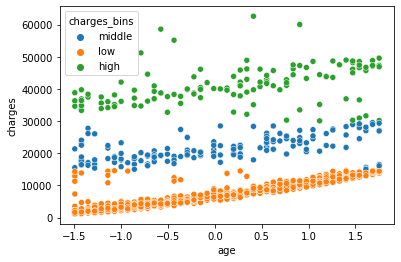

In [22]:
sns.scatterplot(x = 'age', y = 'charges', data = train_df, hue = 'charges_bins')

## Create linear models for each charges_bins


In [23]:
### split the observations according to charges_bins
train_lo = train_df[train_df['charges_bins'] == 'low']
train_md = train_df[train_df['charges_bins'] == 'middle']
train_hi = train_df[train_df['charges_bins'] == 'high']

In [24]:
train_lo.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,charges_bins
1,-1.495300,0.512347,-0.065870,1725.5523,1,0,0,1,0,low
2,-0.789192,0.386433,1.592504,4449.4620,1,0,0,1,0,low
4,-0.506748,-0.287291,-0.895057,3866.8552,1,0,1,0,0,low
5,-0.577359,-0.800760,-0.895057,3756.6216,0,0,0,1,0,low
8,-0.153694,-0.131942,0.763317,6406.4107,1,0,0,0,0,low


In [25]:
### split the clusters to train and valid
from sklearn.model_selection import train_test_split
### we don't need the charges_bins column anymore
X_lo = train_lo.drop(['charges','charges_bins'], axis = 1)
y_lo = train_lo['charges']
X_md = train_md.drop(['charges','charges_bins'], axis = 1)
y_md = train_md['charges']
X_hi = train_hi.drop(['charges','charges_bins'], axis = 1)
y_hi = train_hi['charges']

In [26]:
### Use cross-validation to estimate the performance of the linear regression models on the test dataset
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_validate

cv = KFold(n_splits = 5, random_state = 42, shuffle = True)
cv_results_lo = cross_validate(estimator = LinearRegression()
                               , X = X_lo
                               , y = y_lo
                               , scoring = ['neg_root_mean_squared_error', 'r2']
                               , cv = cv
                               , return_estimator = True)
cv_results_md = cross_validate(estimator = LinearRegression()
                               , X = X_md
                               , y = y_md
                               , scoring = ['neg_root_mean_squared_error', 'r2']
                               , cv = cv
                               , return_estimator = True)
cv_results_hi = cross_validate(estimator = LinearRegression()
                               , X = X_hi
                               , y = y_hi
                               , scoring = ['neg_root_mean_squared_error', 'r2']
                               , cv = cv
                               , return_estimator = True) 


In [27]:
cv_results_lo 

{'fit_time': array([0.01289606, 0.00245047, 0.00234127, 0.00233984, 0.00236845]),
 'score_time': array([0.00252962, 0.00209951, 0.00206661, 0.00203586, 0.00208235]),
 'estimator': [LinearRegression(),
  LinearRegression(),
  LinearRegression(),
  LinearRegression(),
  LinearRegression()],
 'test_neg_root_mean_squared_error': array([-1144.71495517,  -836.66976455, -1842.32583676, -1128.58034344,
        -1263.43195886]),
 'test_r2': array([0.90816471, 0.95570019, 0.76667692, 0.92339537, 0.89717569])}

### On average, how well will the three linear models perform on unseen data?

In [28]:
lr_lo_RMSE = np.mean(abs(cv_results_lo['test_neg_root_mean_squared_error']))
lr_md_RMSE = np.mean(abs(cv_results_md['test_neg_root_mean_squared_error']))
lr_hi_RMSE = np.mean(abs(cv_results_hi['test_neg_root_mean_squared_error']))
lr_combined_RMSE = np.mean([lr_lo_RMSE, lr_md_RMSE, lr_hi_RMSE])
lr_lo_R2 = np.mean(abs(cv_results_lo['test_r2']))
lr_md_R2 = np.mean(abs(cv_results_md['test_r2']))
lr_hi_R2 = np.mean(abs(cv_results_hi['test_r2']))
lr_combined_R2 = np.mean([lr_lo_R2, lr_md_R2, lr_hi_R2])
print('Average RMSE of three linear models on test data: ', lr_combined_RMSE)
print('Average R^2 of three linear models on test data: ', lr_combined_R2)

Average RMSE of three linear models on test data:  2903.6018974830226
Average R^2 of three linear models on test data:  0.5638222403744946


Let's compare the performance of the three models against one single linear model.

In [29]:
X = train_df.drop(['charges', 'charges_bins'], axis = 1)
y = train_df['charges']
lr_single = LinearRegression()
cv_results_single = cross_validate(estimator = lr_single
                               , X = X
                               , y = y
                               , scoring = ['neg_root_mean_squared_error', 'r2']
                               , cv = cv
                               , return_estimator = True)
cv_results_single

{'fit_time': array([0.00402093, 0.00240445, 0.00233555, 0.0023284 , 0.00236177]),
 'score_time': array([0.0022285 , 0.00204468, 0.00202751, 0.00208855, 0.00218058]),
 'estimator': [LinearRegression(),
  LinearRegression(),
  LinearRegression(),
  LinearRegression(),
  LinearRegression()],
 'test_neg_root_mean_squared_error': array([-6102.07144765, -5923.83820031, -6970.99419485, -5859.08150158,
        -5467.8596275 ]),
 'test_r2': array([0.73845205, 0.77655383, 0.72487421, 0.73870668, 0.77877048])}

In [30]:
lr_single_RMSE = np.mean(abs(cv_results_single['test_neg_root_mean_squared_error']))
lr_single_R2 = np.mean(abs(cv_results_single['test_r2']))
print('Average RMSE of a single linear model on test data: ', lr_single_RMSE)
print('Average R^2 of a  single linear model on test data: ', lr_single_R2)

Average RMSE of a single linear model on test data:  6064.768994376047
Average R^2 of a  single linear model on test data:  0.751471452470106


The single linear model explains the variablity of the response better than the three models but it performs much worse when predicting the response.

In [31]:
# X with bins and y with bins (low, middle, high)
X_wbins = train_df.drop(['charges'], axis = 1) 
X_wbins = pd.get_dummies(X_wbins, drop_first = True) 
y_wbins = train_df['charges']

lr_wbins = LinearRegression()
cv_results_wbins = cross_validate(estimator = lr_wbins
                               , X = X_wbins
                               , y = y_wbins
                               , scoring = ['neg_root_mean_squared_error', 'r2']
                               , cv = cv
                               , return_estimator = True)
cv_results_wbins

{'fit_time': array([0.00304747, 0.00265074, 0.00290895, 0.00257134, 0.00250292]),
 'score_time': array([0.002496  , 0.00252056, 0.00218225, 0.00211549, 0.00209785]),
 'estimator': [LinearRegression(),
  LinearRegression(),
  LinearRegression(),
  LinearRegression(),
  LinearRegression()],
 'test_neg_root_mean_squared_error': array([-2287.42292651, -2487.10974306, -3070.04703742, -2464.49262276,
        -2830.60339447]),
 'test_r2': array([0.96324726, 0.96061268, 0.94663802, 0.95376996, 0.94071205])}

In [32]:
lr_wbins_RMSE = np.mean(abs(cv_results_lo['test_neg_root_mean_squared_error']))
lr_wbins_R2 = np.mean(cv_results_lo['test_r2'])
print('Average (estimate) RMSE of a single linear model on test data: ', lr_wbins_RMSE)
print('Average (estimate) R^2 of a single linear model on test data: ', lr_wbins_R2)

Average (estimate) RMSE of a single linear model on test data:  1243.1445717543647
Average (estimate) R^2 of a single linear model on test data:  0.8902225741486898


The single linear models improves drastically as the `charges_bins` column was used as a predictor

# Feature Selection
There three feature selection methods discussed in the book(Chapter 3) were:
1. Forward Selection
2. Backward Selection
3. Mixed Selection

We'll use all three to select features for the single linear regression model.

In [33]:
# Code reference - Feature selection: https://www.datasklr.com/ols-least-squares-regression/variable-selection
import statsmodels.api as sm

def forward_selection(X, y, threshold_in=0.01, verbose=True):
    include = []
    changed = True
    while changed:
        exclude = list(set(X.columns) - set(include))
        pvalues = pd.Series(index=list(X.columns), dtype=float)
        for column in exclude:
            model = sm.OLS(y, sm.add_constant(X[include + [column]])).fit()
            pvalues[column] = model.pvalues[column]
        best_pvalue = pvalues.min()
        if best_pvalue < threshold_in:
            include.append(pvalues.index[pvalues.argmin()])
            if verbose:
                print("Include: {0}\t p-value: {1}".format(pvalues.index[pvalues.argmin()], best_pvalue))
            continue
        changed = False
        
        return include
    
def backward_selection(X, y, threshold_out=0.05, verbose=True):
    include = list(X.columns)
    changed = True
    while changed:
        model = sm.OLS(y, sm.add_constant(X[include])).fit()
        p_values = model.pvalues.iloc[1:]# 0th index is the intercept 
        toremove_pvalue = p_values.max()
        if toremove_pvalue > threshold_out:
            remove_ = p_values.idxmax()
            include.remove(remove_)
            if verbose:
                print("Exclude: {0}\t p-value: {1}".format(remove_, toremove_pvalue))
            continue
        changed = False
        
        return include

In [34]:
selected_features_fwd = forward_selection(X_wbins, y_wbins)
selected_features_bwd = backward_selection(X_wbins, y_wbins, threshold_out = 0.01)
print(selected_features_fwd)
print(selected_features_bwd)

Include: charges_bins_low	 p-value: 1.0198893694727942e-290
Include: charges_bins_middle	 p-value: 2.3322475551369146e-204
Include: age	 p-value: 7.205352580307545e-201
Include: smoker_yes	 p-value: 4.5257798102090453e-17
Include: bmi	 p-value: 3.0883250529641434e-05
Include: children	 p-value: 3.9435434291454515e-05
Include: sex_male	 p-value: 0.008029769675495547
Exclude: region_northwest	 p-value: 0.17358803610660203
Exclude: region_southwest	 p-value: 0.04167849921536705
Exclude: region_southeast	 p-value: 0.05589778307183728
['charges_bins_low', 'charges_bins_middle', 'age', 'smoker_yes', 'bmi', 'children', 'sex_male']
['age', 'bmi', 'children', 'sex_male', 'smoker_yes', 'charges_bins_low', 'charges_bins_middle']


In [35]:
# Creating a model using the selected features
lr_sel = LinearRegression()
cv_results_sel = cross_validate(estimator = lr_sel
                               , X = X_wbins[selected_features_fwd]
                               , y = y_wbins
                               , scoring = ['neg_root_mean_squared_error', 'r2']
                               , cv = cv
                               , return_estimator = True)
cv_results_sel

{'fit_time': array([0.00366163, 0.00240111, 0.0023942 , 0.00240493, 0.00233102]),
 'score_time': array([0.00233984, 0.00211287, 0.00208354, 0.00208139, 0.00202918]),
 'estimator': [LinearRegression(),
  LinearRegression(),
  LinearRegression(),
  LinearRegression(),
  LinearRegression()],
 'test_neg_root_mean_squared_error': array([-2301.70074397, -2489.5151026 , -3067.22036692, -2439.78224244,
        -2849.90046151]),
 'test_r2': array([0.96278702, 0.96053646, 0.94673624, 0.95469237, 0.93990093])}

In [36]:
lr_sel_RMSE = np.mean(abs(cv_results_sel['test_neg_root_mean_squared_error']))
lr_sel_R2 = np.mean(cv_results_sel['test_r2'])
print('Average RMSE of a single linear model on test data: ', lr_sel_RMSE)
print('Average R^2 of a single linear model on test data: ', lr_sel_R2)

Average RMSE of a single linear model on test data:  2629.6237834889307
Average R^2 of a single linear model on test data:  0.9529306035517185


### Would the three linear models perform better with the right features?


In [37]:
selected_lo_fwd = forward_selection(X_lo, y_lo, verbose = False)
selected_md_fwd = forward_selection(X_md, y_md, verbose = False)
selected_hi_fwd = forward_selection(X_hi, y_hi, verbose = False)
selected_lo_bwd = backward_selection(X_lo, y_lo, verbose = False)
selected_md_bwd = backward_selection(X_md, y_md, verbose = False)
selected_hi_bwd = backward_selection(X_hi, y_hi, verbose = False)
print('fwd_lo: ', selected_lo_fwd, '\n bwd_lo: ', selected_lo_bwd)
print('fwd_md: ', selected_md_fwd, '\n bwd_md: ', selected_md_bwd)
print('fwd_hi: ', selected_hi_fwd, '\n bwd_hi: ', selected_hi_bwd)

fwd_lo:  ['age', 'smoker_yes', 'children', 'sex_male', 'region_southwest', 'region_southeast', 'region_northwest'] 
 bwd_lo:  ['age', 'children', 'sex_male', 'smoker_yes', 'region_northwest', 'region_southeast', 'region_southwest']
fwd_md:  ['age'] 
 bwd_md:  ['age']
fwd_hi:  ['age', 'smoker_yes', 'bmi'] 
 bwd_hi:  ['age', 'bmi', 'smoker_yes']


In [38]:
cv_results_lo_sel = cross_validate(estimator = LinearRegression()
                               , X = X_lo[selected_lo_fwd]
                               , y = y_lo
                               , scoring = ['neg_root_mean_squared_error', 'r2']
                               , cv = cv
                               , return_estimator = True)
cv_results_md_sel = cross_validate(estimator = LinearRegression()
                               , X = X_md[selected_md_fwd]
                               , y = y_md
                               , scoring = ['neg_root_mean_squared_error', 'r2']
                               , cv = cv
                               , return_estimator = True)
cv_results_hi_sel = cross_validate(estimator = LinearRegression()
                               , X = X_hi[selected_hi_fwd]
                               , y = y_hi
                               , scoring = ['neg_root_mean_squared_error', 'r2']
                               , cv = cv
                               , return_estimator = True) 


In [39]:
cv_results_hi_sel

{'fit_time': array([0.00213695, 0.00211406, 0.00224996, 0.00217056, 0.00206423]),
 'score_time': array([0.00194407, 0.00187182, 0.00193048, 0.00191808, 0.00192499]),
 'estimator': [LinearRegression(),
  LinearRegression(),
  LinearRegression(),
  LinearRegression(),
  LinearRegression()],
 'test_neg_root_mean_squared_error': array([-4603.30630188, -1727.57019222, -5671.21897664, -3915.44418355,
        -3057.01003545]),
 'test_r2': array([0.50394135, 0.86112857, 0.40421859, 0.50804164, 0.67020172])}

In [40]:
lr_lo_sel_RMSE = np.mean(abs(cv_results_lo_sel['test_neg_root_mean_squared_error']))
lr_md_sel_RMSE = np.mean(abs(cv_results_md_sel['test_neg_root_mean_squared_error']))
lr_hi_sel_RMSE = np.mean(abs(cv_results_hi_sel['test_neg_root_mean_squared_error']))
lr_combined_sel_RMSE = np.mean([lr_lo_sel_RMSE, lr_md_sel_RMSE, lr_hi_sel_RMSE])
lr_lo_sel_R2 = np.mean(abs(cv_results_lo_sel['test_r2']))
lr_md_sel_R2 = np.mean(abs(cv_results_md_sel['test_r2']))
lr_hi_sel_R2 = np.mean(abs(cv_results_hi_sel['test_r2']))
lr_combined_sel_R2 = np.mean([lr_lo_sel_R2, lr_md_sel_R2, lr_hi_sel_R2])
print('Average RMSE of three linear models on test data: ', lr_combined_sel_RMSE)
print('Average R^2 of three linear models on test data: ', lr_combined_sel_R2)

Average RMSE of three linear models on test data:  2742.822999591728
Average R^2 of three linear models on test data:  0.5914829448557021


In [41]:
### Input visualization here, comparing the RMSE and R^2 on all approaches

# Create a classifier

In [42]:
train_df.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,charges_bins
0,-1.424689,-0.447546,-0.895057,16884.9240,0,1,0,0,1,middle
1,-1.495300,0.512347,-0.065870,1725.5523,1,0,0,1,0,low
2,-0.789192,0.386433,1.592504,4449.4620,1,0,0,1,0,low
4,-0.506748,-0.287291,-0.895057,3866.8552,1,0,1,0,0,low
5,-0.577359,-0.800760,-0.895057,3756.6216,0,0,0,1,0,low


In [43]:
X = train_df.drop(['charges', 'charges_bins'], axis = 1)
y = train_df['charges_bins']
bins = {'low': 0, 'middle': 1, 'high': 2 }
y = y.map(bins)


In [44]:
y.value_counts()

0    785
1    153
2    132
Name: charges_bins, dtype: int64

There is a class imbalance between the classes. Let's balance the classes using undersampling

In [45]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_res, y_res = rus.fit_resample(X, y)


In [46]:
y_res.value_counts()

0    132
1    132
2    132
Name: charges_bins, dtype: int64

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.20, random_state = 42)

In [48]:
param_grid_lr = {
    'max_iter': [20, 50, 100, 200, 500, 1000],                      
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],   
    'class_weight': ['balanced']                                    
}

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
logModel_grid = GridSearchCV(estimator=LogisticRegression(random_state=42), param_grid=param_grid_lr, scoring='f1_weighted', verbose=1, cv=10, n_jobs=-1)
logModel_grid.fit(X_train, y_train)
print(logModel_grid.best_estimator_) 

Fitting 10 folds for each of 30 candidates, totalling 300 fits
LogisticRegression(class_weight='balanced', max_iter=20, random_state=42,
                   solver='liblinear')


In [50]:
y_pred = logModel_grid.predict(X_test)
print(y_pred)

[0 2 0 0 2 2 0 2 0 0 0 1 2 1 2 2 0 2 1 2 1 2 2 0 0 0 0 0 0 1 2 1 2 2 0 2 2
 0 0 0 0 2 2 2 0 0 0 2 0 1 0 0 0 2 0 0 2 2 0 0 0 0 2 0 2 0 0 0 2 0 0 0 1 0
 2 0 0 0 1 1]


In [51]:
from sklearn.metrics import confusion_matrix, classification_report
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print('classification Report: \n', classification_report(y_test, y_pred))

Confusion Matrix:
 [[33  3  0]
 [ 9  7  7]
 [ 1  0 20]]
classification Report: 
               precision    recall  f1-score   support

           0       0.77      0.92      0.84        36
           1       0.70      0.30      0.42        23
           2       0.74      0.95      0.83        21

    accuracy                           0.75        80
   macro avg       0.74      0.72      0.70        80
weighted avg       0.74      0.75      0.72        80



In [52]:
print('confusion matrix \n', confusion_matrix(y_test, y_pred))
print('classification report \n', classification_report(y_test, y_pred))

confusion matrix 
 [[33  3  0]
 [ 9  7  7]
 [ 1  0 20]]
classification report 
               precision    recall  f1-score   support

           0       0.77      0.92      0.84        36
           1       0.70      0.30      0.42        23
           2       0.74      0.95      0.83        21

    accuracy                           0.75        80
   macro avg       0.74      0.72      0.70        80
weighted avg       0.74      0.75      0.72        80



### Feature Selection in Logistic Regression

In [53]:
from sklearn.feature_selection import SequentialFeatureSelector
## SequentialFeatureSelector using f1_micro
logreg = logModel_grid.best_estimator_
SFS_forward = SequentialFeatureSelector(logreg, n_features_to_select = 4 , direction = 'forward', scoring='f1_weighted', cv = 5)
SFS_forward.fit(X_train, y_train)
selected_SFS_forward = X_train.columns[SFS_forward.support_]
removed_SFS_forward = X_train.columns[~SFS_forward.support_]

In [54]:
selected_SFS_forward

Index(['age', 'bmi', 'smoker_yes', 'region_southwest'], dtype='object')

In [55]:
SFS_backward = SequentialFeatureSelector(logreg, n_features_to_select = 4 , direction = 'backward', scoring='f1_weighted', cv = 5)
SFS_backward.fit(X_train, y_train)
selected_SFS_backward = X_train.columns[SFS_backward.support_]
removed_SFS_backward = X_train.columns[~SFS_backward.support_]

In [56]:
selected_SFS_backward

Index(['bmi', 'children', 'smoker_yes', 'region_southwest'], dtype='object')

In [57]:
logModel_grid = GridSearchCV(estimator=LogisticRegression(random_state=42), param_grid=param_grid_lr, scoring='f1_weighted', verbose=1, cv=10, n_jobs=-1)
logModel_grid.fit(X_train[selected_SFS_forward], y_train)
y_pred_sel = logModel_grid.predict(X_test[selected_SFS_forward])
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_sel))
print('classification Report: \n', classification_report(y_test, y_pred_sel))

Fitting 10 folds for each of 30 candidates, totalling 300 fits
Confusion Matrix:
 [[35  1  0]
 [11 11  1]
 [ 1  1 19]]
classification Report: 
               precision    recall  f1-score   support

           0       0.74      0.97      0.84        36
           1       0.85      0.48      0.61        23
           2       0.95      0.90      0.93        21

    accuracy                           0.81        80
   macro avg       0.85      0.79      0.79        80
weighted avg       0.83      0.81      0.80        80



/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [58]:
### Not yet finished

Priscila's code for this dataset was able to produce a better model than the one I made here. However, as stated in the beginning the goal of this notebook is to apply the concepts I learned from ISLR. You can check out her article from the link below.


Vanny, P. (2021 May 17). Linear Regression with K-Fold Cross Validation in Python: Predict the Health Insurance Cost. *Medium*. https://priscilla-vanny.medium.com/linear-regression-with-k-fold-cross-validation-in-python-predict-the-health-insurance-cost-7badf90fc1b8

TODO:
- [ ] Finish kaggle [/]
  - [ ] Compare undersampling and oversampling, which is better?
  - [ ] evaluate the performanceof your models on the test dataset
  - [ ] rename variables 
  - [ ] explain what you did
  - [ ] interpret model
  - [ ] compare your linear models to complex models


# Continue EDA tomorrow, also check other people's codes to learn more.

Use this notebook for inspiration. https://www.kaggle.com/ahmetsulukaya/regression-model. dont forget to reference it

> Note to self, need to encode variables first before making a model.

Do this after EDA maybe:
https://www.datasklr.com/ols-least-squares-regression/variable-selection

TODO:
- Needs improvement in the EDA. I should include others as well. I mean, I should not stop at smoker column. 
> Even if you've found something, dont stop there. Just keep it in mind and continue investigating. When all is done then you can test what you've found.


References:
- Resampling imbalanced datasets: https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets
- Optimizing threshold for logistic regression: https://towardsdatascience.com/calculating-and-setting-thresholds-to-optimise-logistic-regression-performance-c77e6d112d7e
- Optimizing threshold for multi-class: https://datascience.stackexchange.com/questions/77264/finding-optimal-threshold-in-multi-class-classification-task
- Optimize Logistic regression: https://medium.com/analytics-vidhya/how-to-improve-logistic-regression-b956e72f4492
- Maurício Collaça's comment: https://stackoverflow.com/questions/57085897/python-logistic-regression-max-iter-parameter-is-reducing-the-accuracy
- Regression model: https://www.kaggle.com/ahmetsulukaya/regression-model
- Feature selection: https://www.datasklr.com/ols-least-squares-regression/variable-selection
- Feature Elimination Examples for Logistic Regression: https://darigak.medium.com/feature-elimination-examples-for-logistic-regression-7293462e197b
- https://stackoverflow.com/questions/59538006/scaling-data-frame-with-numeric-and-categorical
- K-Fold cross validation in python: https://www.statology.org/k-fold-cross-validation-in-python/

Reflections:
1. Without using cross-validation, we cannot estimate properly how the model will perform on unseen data. What I did in the first version of this notebook was create a linear model from a single train and test(validation) set. So everytime I restart the notebook I get different results, sometimes the models perform well other times not. 
